In [2]:
# Importing core libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Downloading required NLTK datasets for stopwords and lemmatization
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Setting the seaborn style for plots
sns.set(style="whitegrid")

# Loading the dataset from Colab's file system
df = pd.read_csv("/content/Fitness Articles.csv")

# Combining 'headline' and 'abstract' into a single text column for analysis
df['text'] = df['headline'].fillna('') + '. ' + df['abstract'].fillna('')

# Dropping the 'lead_paragraph' column as it is completely empty
df.drop(columns=['lead_paragraph'], inplace=True)

print("Dataset loaded. Number of articles:", len(df))
print("Columns in dataset:", df.columns.tolist())

Dataset loaded. Number of articles: 530
Columns in dataset: ['headline', 'abstract', 'pub_date', 'web_url', 'text']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Step 2: Text preprocessing pipeline (lowercase, remove punctuation, remove stopwords, lemmatize)
# We'll use NLTK for tokenization, stopwords, and lemmatization.
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
# Download 'punkt_tab' data package:
nltk.download('punkt_tab', quiet=True) # This line is added to download the necessary data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Initialize stopwords list and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Clean and preprocess a single document string."""
    # 1. Lowercase the text
    text = text.lower()
    # 2. Remove punctuation and non-alphabetic characters (retain words and spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 3. Tokenize the text into words
    tokens = word_tokenize(text)
    # 4. Remove stopwords and any leftover single-character tokens
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    # 5. Lemmatize the tokens (convert to base form)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply preprocessing to each article's text.
# We need to identify which column contains the main text; assume it's named 'content' or similar.
text_column = 'content' if 'content' in df.columns else df.columns[0]  # use first column if unsure
processed_docs = df[text_column].astype(str).apply(preprocess_text)

# Check a sample of the preprocessing result
print("Sample original text:", df[text_column].iloc[0][:100], "...")
print("After preprocessing (tokens):", processed_docs.iloc[0][:10], "...")
# We show only first 100 chars of original and first 10 tokens of processed text for brevity.

Sample original text: Can Grunting During Exercise Give You an Edge? ...
After preprocessing (tokens): ['grunting', 'exercise', 'give', 'edge'] ...


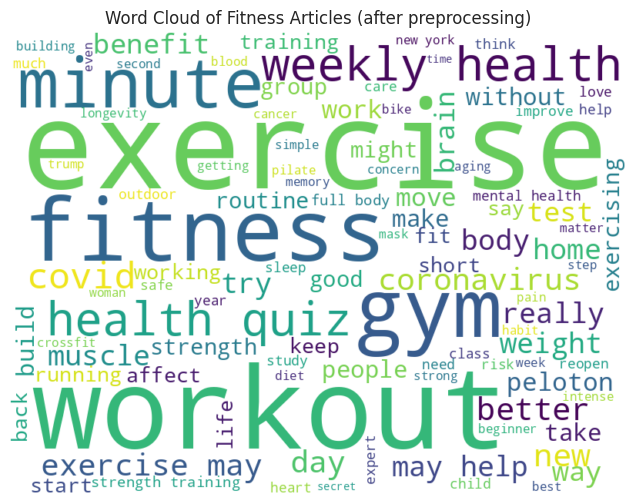

In [4]:
# Step 3: Generate a word cloud from the preprocessed text
# We'll combine all tokens from all documents into one large text for the word cloud.
all_tokens = [token for tokens in processed_docs for token in tokens]
all_text = " ".join(all_tokens)

# Create a word cloud image of the most frequent words
wordcloud = WordCloud(width=800, height=600, background_color='white', colormap='viridis',
                      max_words=100).generate(all_text)

# Plot the word cloud
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Fitness Articles (after preprocessing)")
plt.show()
# The word cloud gives a visual sense of the most common words in the corpus after cleaning.

In [5]:
# Step 4: Vectorize the documents using CountVectorizer and TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Before vectorization, join tokens back into string form for each document (needed for vectorizers).
docs_cleaned = [" ".join(tokens) for tokens in processed_docs]

# Set up vectorizers with appropriate min_df and max_df to ignore extremely rare/common words.
# For example, ignore words that appear in more than 90% of documents or fewer than 5 documents.
min_df_val = 5  # ignore words that appear in fewer than 5 articles
max_df_val = 0.9  # ignore words that appear in more than 90% of the articles
count_vect = CountVectorizer(min_df=min_df_val, max_df=max_df_val)
tfidf_vect = TfidfVectorizer(min_df=min_df_val, max_df=max_df_val)

# Fit and transform the cleaned documents
count_matrix = count_vect.fit_transform(docs_cleaned)
tfidf_matrix = tfidf_vect.fit_transform(docs_cleaned)
print("CountVectorizer: number of documents =", count_matrix.shape[0], ", number of features =", count_matrix.shape[1])
print("TF-IDF Vectorizer: number of features =", tfidf_matrix.shape[1])
# These outputs show the dimensions of our document-term matrices.
# Features are the unique words remaining after preprocessing and filtering by df thresholds.

# Let's display a few example features to see what words are included:
feature_names = count_vect.get_feature_names_out()
print("Sample features (words) from CountVectorizer:", feature_names[:10])

CountVectorizer: number of documents = 530 , number of features = 102
TF-IDF Vectorizer: number of features = 102
Sample features (words) from CountVectorizer: ['affect' 'aging' 'back' 'beginner' 'benefit' 'best' 'better' 'blood'
 'body' 'brain']


In [6]:
# Step 5: Fitting LDA models with different topic numbers using scikit-learn

from sklearn.decomposition import LatentDirichletAllocation
import time

# Define a list of topic numbers to experiment with
topic_nums = [5, 6, 7, 8, 10]

# Store models and training times
lda_models = {}
training_times = {}

# Fit LDA models with different topic counts
for num_topics in topic_nums:
    lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=10,
                                          learning_method='batch', random_state=42)
    start_time = time.time()
    lda_model.fit(count_matrix)
    elapsed = time.time() - start_time
    lda_models[num_topics] = lda_model
    training_times[num_topics] = elapsed
    print(f"Trained LDA model with {num_topics} topics in {elapsed:.2f} seconds.")

Trained LDA model with 5 topics in 1.27 seconds.
Trained LDA model with 6 topics in 2.69 seconds.
Trained LDA model with 7 topics in 1.29 seconds.
Trained LDA model with 8 topics in 0.95 seconds.
Trained LDA model with 10 topics in 1.26 seconds.


In [7]:
# Step 6: Extracting top keywords for each topic across all models
# This will help decide which topic number is most interpretable

# Set number of top words to show per topic
num_top_words = 10
feature_names = count_vect.get_feature_names_out()

# Loop through each LDA model and display top keywords for each topic
for num_topics, model in lda_models.items():
    print(f"\nTop {num_top_words} words for each of the {num_topics} LDA topics:")
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-num_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"  Topic {topic_idx + 1}: {', '.join(top_words)}")


Top 10 words for each of the 5 LDA topics:
  Topic 1: workout, gym, minute, body, strength, benefit, training, full, build, get
  Topic 2: health, better, muscle, make, good, mental, running, keep, fit, study
  Topic 3: fitness, test, new, way, peloton, group, exercising, home, could, life
  Topic 4: exercise, may, help, get, work, weight, take, might, health, brain
  Topic 5: workout, health, exercise, quiz, weekly, covid, try, coronavirus, move, best

Top 10 words for each of the 6 LDA topics:
  Topic 1: gym, workout, strength, training, minute, without, home, peloton, reopen, build
  Topic 2: health, fitness, better, make, good, mental, fit, expert, love, say
  Topic 3: fitness, test, benefit, new, way, exercising, could, group, life, home
  Topic 4: exercise, may, help, get, work, take, working, affect, day, brain
  Topic 5: workout, minute, body, muscle, move, try, weight, best, really, time
  Topic 6: health, exercise, weekly, quiz, covid, coronavirus, weight, risk, year, sleep


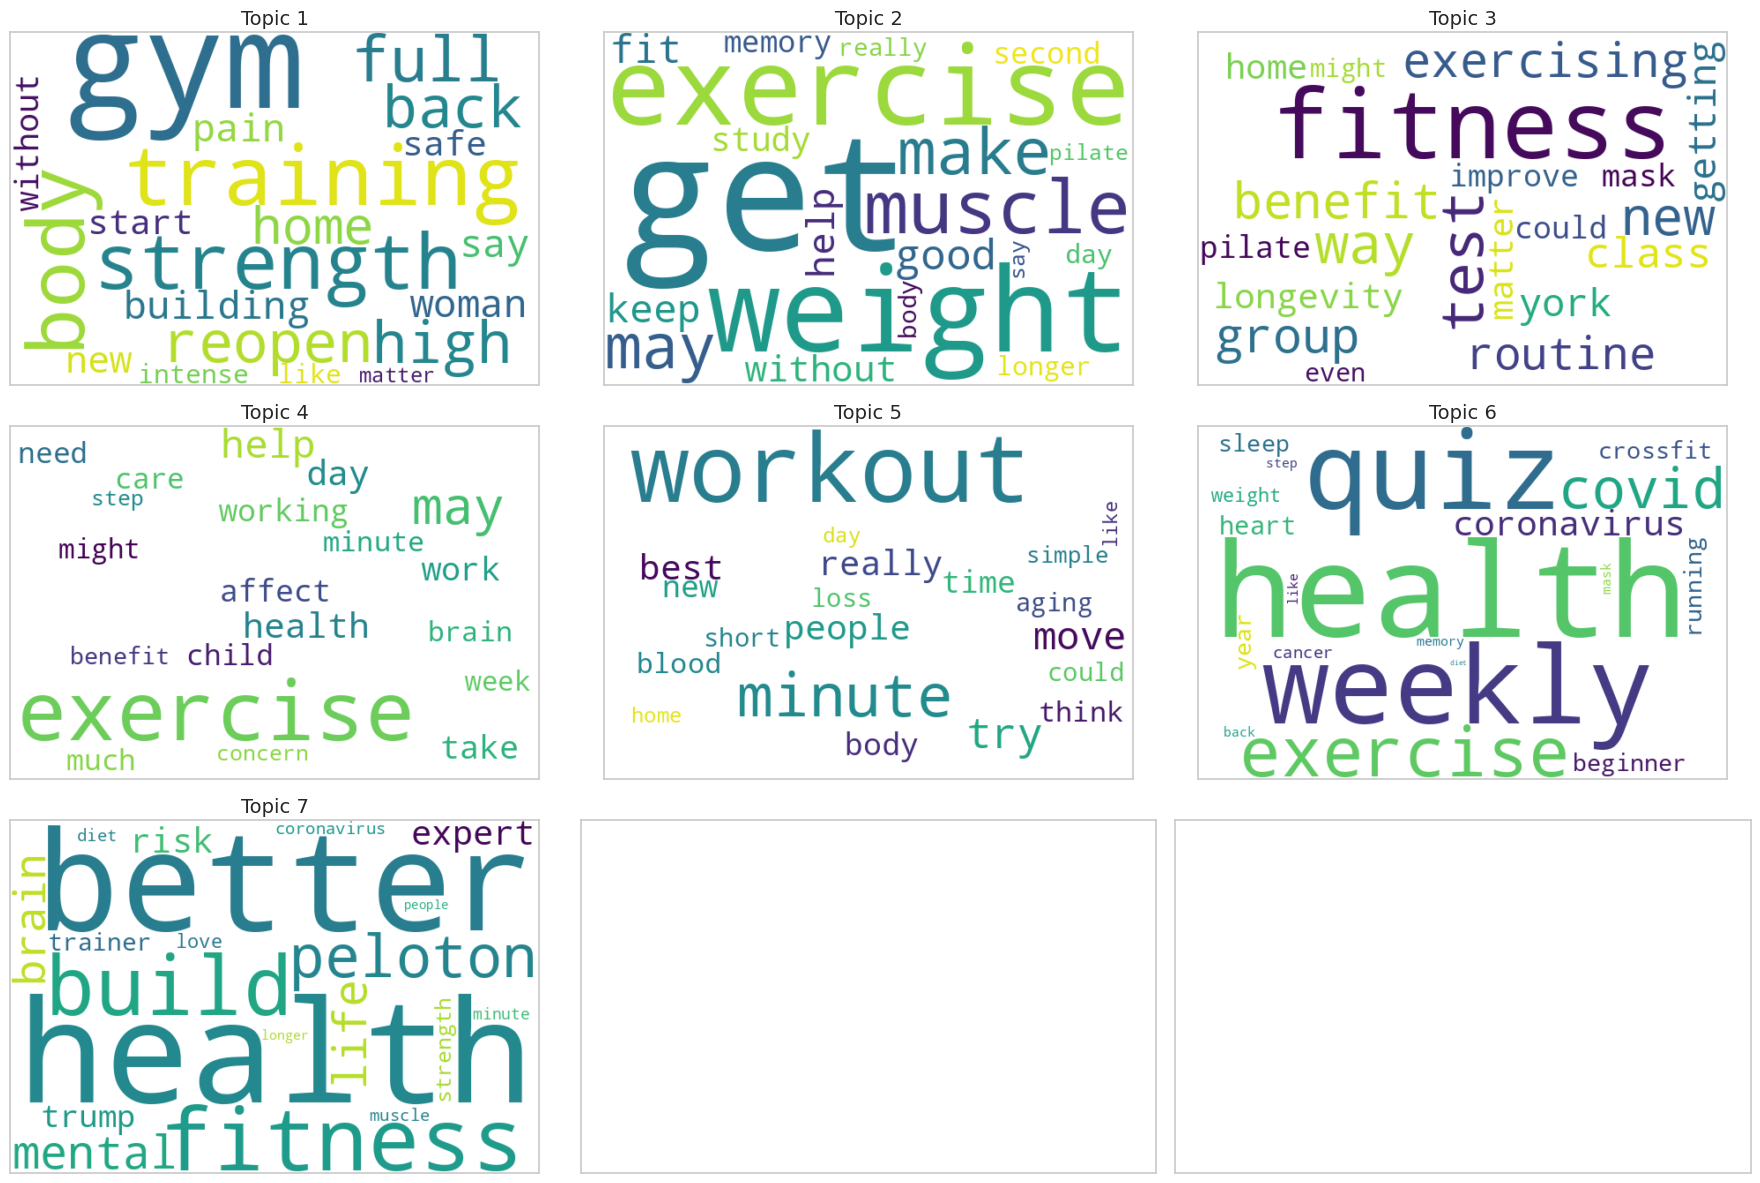

In [8]:
# Step 7: Visualizing each topic using WordClouds

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set which LDA model to use for visualization (change to 6 or 8 if needed)
selected_model = lda_models[7]
feature_names = count_vect.get_feature_names_out()

# Set number of top words to display in each topic's word cloud
num_words = 20

# Generate word clouds
fig, axes = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flatten()

for topic_idx, topic in enumerate(selected_model.components_):
    if topic_idx >= 9:
        break
    top_indices = topic.argsort()[:-num_words - 1:-1]
    topic_words = {feature_names[i]: topic[i] for i in top_indices}
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(topic_words)
    axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
    axes[topic_idx].set_title(f"Topic {topic_idx + 1}", fontsize=14)

plt.tight_layout()
plt.show()

In [12]:
# Step 8: NMF Topic Modeling (Clean version, nltk-free)

import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Load dataset
df = pd.read_csv("/content/Fitness Articles.csv")
df['text'] = df['headline'].fillna('') + '. ' + df['abstract'].fillna('')

# Basic cleaner (no nltk)
def clean(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = " ".join([word for word in text.split() if len(word) > 2])
    return text

df['cleaned'] = df['text'].astype(str).apply(clean)

# TF-IDF
tfidf = TfidfVectorizer(min_df=5, max_df=0.9)
X = tfidf.fit_transform(df['cleaned'])

# Fit NMF
nmf_model = NMF(n_components=7, random_state=42)
W = nmf_model.fit_transform(X)
H = nmf_model.components_

# Show topics
feature_names = tfidf.get_feature_names_out()
for idx, topic in enumerate(H):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {idx + 1}: {', '.join(top_words)}")

Topic 1: the, fitness, for, and, that, health, from, about, what, gym
Topic 2: health, knowledge, quiz, weekly, news, week, test, this, your, and
Topic 3: you, can, what, your, but, make, need, help, this, workout
Topic 4: workout, move, minute, your, body, strength, try, full, build, routine
Topic 5: exercise, may, that, our, for, study, workouts, benefits, day, help
Topic 6: are, gyms, and, with, their, people, some, fitness, coronavirus, gym
Topic 7: how, get, here, out, working, start, your, ways, when, exercise


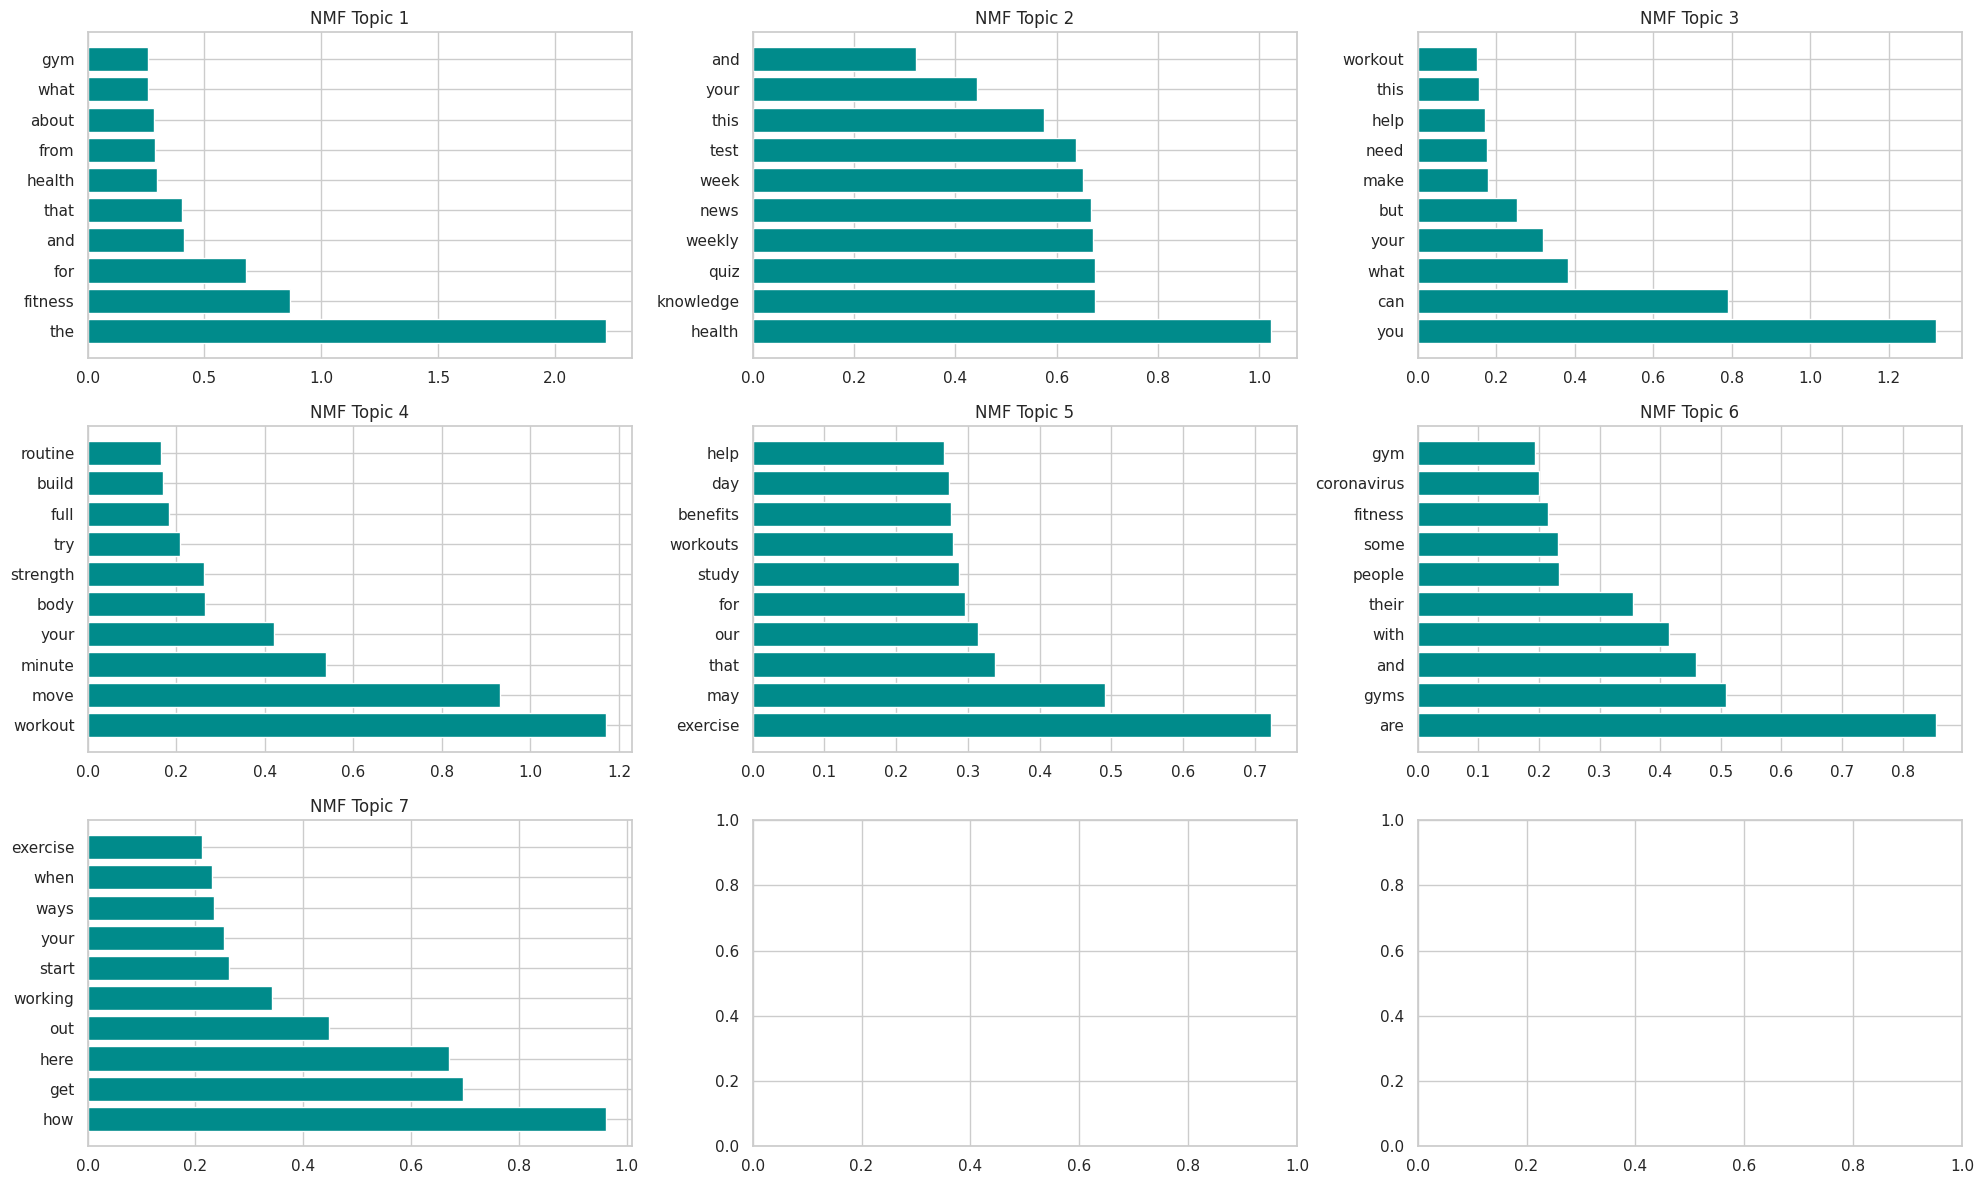

In [13]:
import matplotlib.pyplot as plt

# Define number of top words to display
num_top_words = 10

# Create bar charts for NMF topics
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, topic in enumerate(H):
    if idx >= len(axes):
        break
    top_indices = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = topic[top_indices]

    axes[idx].barh(top_words[::-1], top_scores[::-1], color="darkcyan")
    axes[idx].set_title(f"NMF Topic {idx+1}")
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

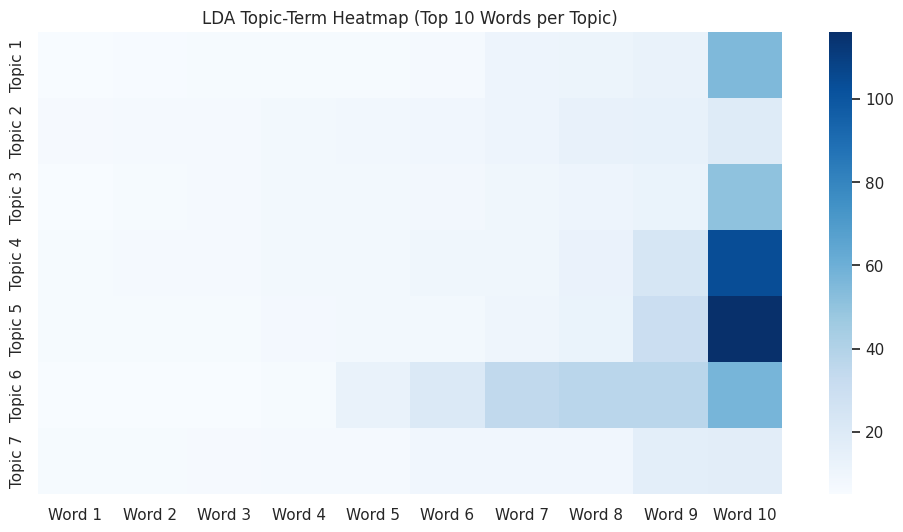

In [16]:
# Correct LDA heatmap generation (top 10 words per topic)

import seaborn as sns
import matplotlib.pyplot as plt

# Number of topics and words
num_topics = 7
num_words = 10

# Get the top word indices for each topic
lda_top_indices = np.argsort(lda_models[7].components_, axis=1)[:, -num_words:]

# Prepare the DataFrame
lda_top_words = []
for topic_idx, word_indices in enumerate(lda_top_indices):
    lda_top_words.append([count_vect.get_feature_names_out()[i] for i in word_indices])

# Create a DataFrame of scores
lda_scores = np.take_along_axis(lda_models[7].components_, lda_top_indices, axis=1)

lda_df = pd.DataFrame(lda_scores,
                      index=[f"Topic {i+1}" for i in range(num_topics)],
                      columns=[f"Word {i+1}" for i in range(num_words)])

plt.figure(figsize=(12, 6))
sns.heatmap(lda_df, cmap="Blues", annot=False, cbar=True)
plt.title("LDA Topic-Term Heatmap (Top 10 Words per Topic)")
plt.show()


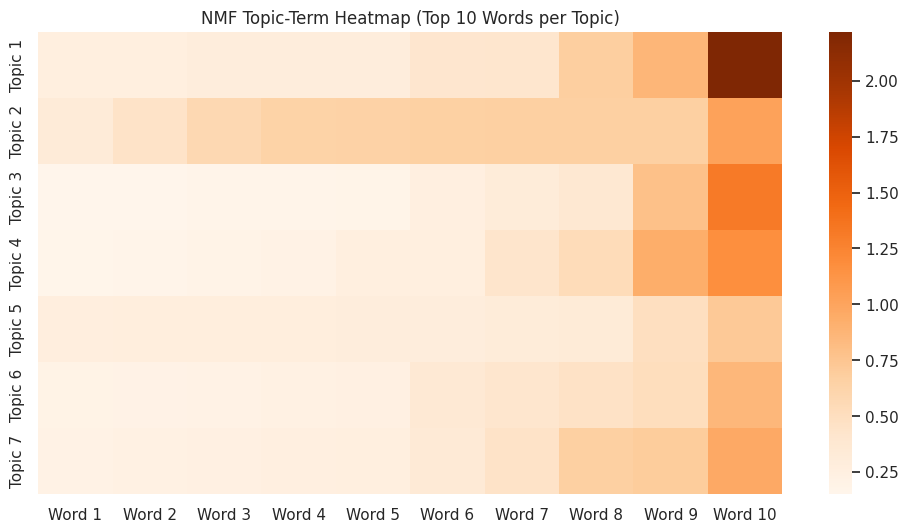

In [17]:
# NMF Topic-Term Heatmap (Top 10 Words per Topic)

# Number of topics and words
num_topics = 7
num_words = 10

# Get top word indices for each topic
nmf_top_indices = np.argsort(H, axis=1)[:, -num_words:]

# Prepare word labels
nmf_top_words = []
for topic_idx, word_indices in enumerate(nmf_top_indices):
    nmf_top_words.append([tfidf.get_feature_names_out()[i] for i in word_indices])

# Get corresponding term scores
nmf_scores = np.take_along_axis(H, nmf_top_indices, axis=1)

# Build DataFrame
nmf_df = pd.DataFrame(nmf_scores,
                      index=[f"Topic {i+1}" for i in range(num_topics)],
                      columns=[f"Word {i+1}" for i in range(num_words)])

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(nmf_df, cmap="Oranges", annot=False, cbar=True)
plt.title("NMF Topic-Term Heatmap (Top 10 Words per Topic)")
plt.show()

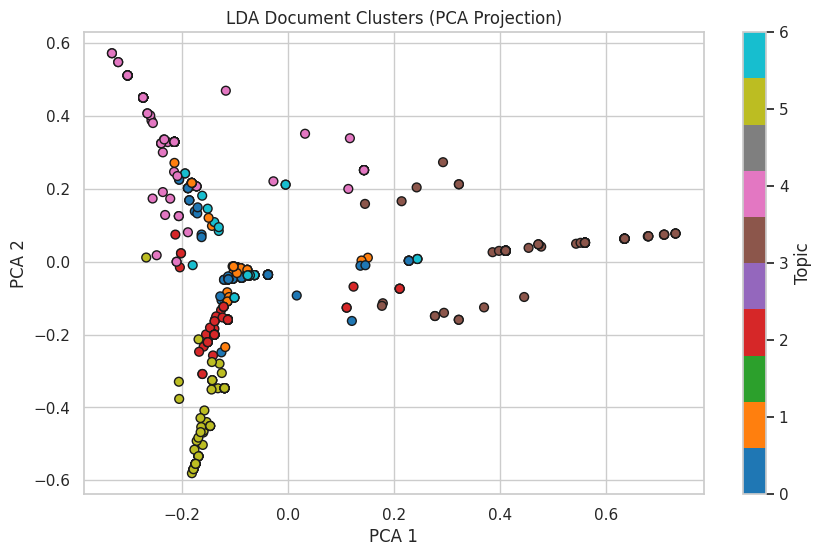

In [18]:
from sklearn.decomposition import PCA

# Use document-topic distribution from the best LDA model
lda_doc_topic = lda_models[7].transform(count_matrix)

# Apply PCA to reduce to 2D
pca_lda = PCA(n_components=2, random_state=42)
lda_2d = pca_lda.fit_transform(lda_doc_topic)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(lda_2d[:, 0], lda_2d[:, 1], c=np.argmax(lda_doc_topic, axis=1),
                      cmap='tab10', s=40, edgecolor='k')
plt.title("LDA Document Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, ticks=range(7), label="Topic")
plt.grid(True)
plt.show()

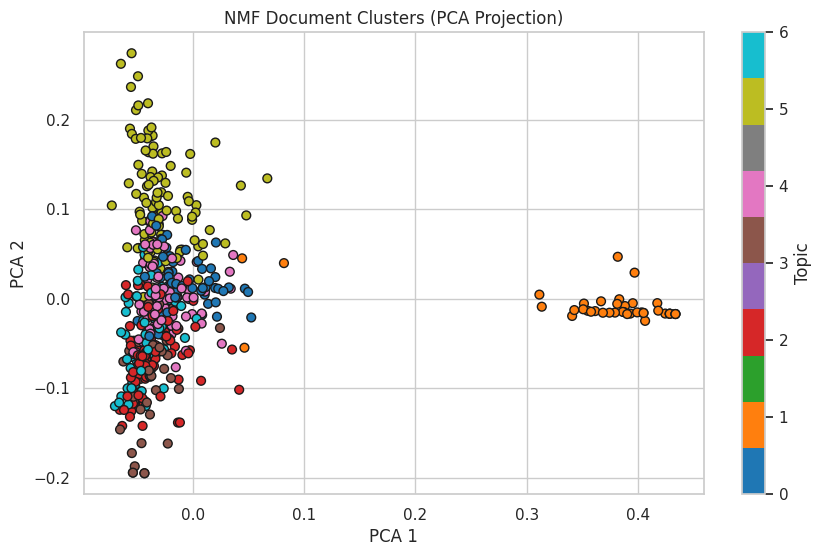

In [19]:
# Use document-topic matrix W from NMF
pca_nmf = PCA(n_components=2, random_state=42)
nmf_2d = pca_nmf.fit_transform(W)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(nmf_2d[:, 0], nmf_2d[:, 1], c=np.argmax(W, axis=1),
                      cmap='tab10', s=40, edgecolor='k')
plt.title("NMF Document Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, ticks=range(7), label="Topic")
plt.grid(True)
plt.show()